# Fine tuning VGG19

In this notebook we will be fine tuning VGG19 using two different approaches.  

In the first, we will replace the last Dense layer with one with 2 outputs and re-train the model with the weights fixed for all pre-existing layers (layer.trainable = False). This method still requires a forward pass through the entire network. We will also explore training the finetuned network after different layers

In the second, we will pop the last layer from VGG19 and use the model to precommute the penultimate layer, using those results to train a linear classifier.

## Imports

In [1]:
# core imports
import os, sys, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from itertools import chain

%matplotlib inline

In [2]:
# adds parent directory to python path so we can access the pre-trained models in keras_models director
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path: sys.path.append(nb_dir)

In [3]:
# ml imports
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

from pretrained_models.vgg19 import VGG19
from pretrained_models.vgg16 import VGG16
from pretrained_models.imagenet_utils import preprocess_input, decode_predictions

Using TensorFlow backend.


## Utility code

In [43]:
import bcolz

def get_batches(dirname, gen=image.ImageDataGenerator(), target_size=(224,224), 
                class_mode='categorical', batch_size=4, shuffle=True):
    return gen.flow_from_directory(dirname, target_size, class_mode=class_mode, batch_size=batch_size, shuffle=shuffle)

def get_data(dirname, target_size=(224,224)):
    batches = get_batches(dirname, target_size=target_size, class_mode=None, batch_size=1, shuffle=False)
    return np.concatenate([ batches.next() for i in range(batches.n) ])

# finetuning
def finetune(model, n_outputs, n_layers_to_remove=1):
    '''
    Removes n_layers from top of the model's layer stack and appends a new
    Dense layer with n_outputs
    '''
    # remove n_layers and fix remaining layer weights
    del model.layers[-n_layers_to_remove:]
    for layer in model.layers: layer.trainable = False
        
    # update the model outputs = the output from the last layer
    model.outputs = [model.layers[-1].output]

    # recover the output from the last layer in the model and use as input to new Dense layer
    last = model.layers[-1].output
    x = Dense(n_outputs, activation="softmax")(last)
    ft_model = Model(model.input, x)
    
    compile(ft_model)
    return ft_model

def compile(model, lr=0.001):
    model.compile(optimizer=RMSprop(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    

# utils
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Define paths and global variables

In [5]:
DATA_DIR = 'data/'

# path = DATA_DIR
path = DATA_DIR + 'sample/'

train_path = path + 'train/'
val_path = path + 'valid/'
test_path = DATA_DIR + 'test/'

models_path = path + 'models/'
results_path = path + 'results/'

if not os.path.exists(models_path): os.makedirs(models_path)
if not os.path.exists(results_path): os.makedirs(results_path)

In [6]:
batch_size = 4 #64

## Preprocess the data

We can save time by pre-processing the images (e.g., converting them to jpegs, resizing to 224x224) and saving them as a numpy array on the file system.  We can do the same for the train, validation, and test image class designations, filenames, and one-hot encoded labels

In [7]:
# use batch_size = 1 since we're just preprocessing on the CPU
train_batches = get_batches(train_path, batch_size=1, shuffle=False)
val_batches = get_batches(val_path, batch_size=1, shuffle=False)
test_batches = get_batches(test_path, batch_size=1, shuffle=False)

Found 300 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [8]:
train_data = get_data(train_path)
train_classes = train_batches.classes
train_labels = onehot(train_classes)
train_filenames = train_batches.filenames

val_data = get_data(val_path)
val_classes = val_batches.classes
val_labels = onehot(val_classes)
val_filenames = val_batches.filenames

test_data = get_data(test_path)
test_filenames = test_batches.filenames

# print(train_data.shape)
# print(val_data.shape)
# print(test_data.shape)

Found 300 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [9]:
save_array(path+'train_data.bc', train_data)
save_array(path+'train_classes.bc', train_classes)
save_array(path+'train_labels.bc', train_labels)
save_array(path+'train_filenames.bc', train_filenames)

save_array(path+'val_data.bc', val_data)
save_array(path+'val_classes.bc', val_classes)
save_array(path+'val_labels.bc', val_labels)
save_array(path+'val_filenames.bc', val_filenames)

save_array(path+'test_data.bc', test_data)
save_array(path+'test_filenames.bc', test_filenames)

In [10]:
train_data = load_array(path+'train_data.bc')
train_classes = load_array(path+'train_classes.bc')
train_labels = load_array(path+'train_labels.bc')
train_filenames = load_array(path+'train_filenames.bc')

val_data = load_array(path+'val_data.bc')
val_classes = load_array(path+'val_classes.bc')
val_labels = load_array(path+'val_labels.bc')
val_filenames = load_array(path+'val_filenames.bc')

test_data = load_array(path+'test_data.bc')
test_filenames = load_array(path+'test_filenames.bc')

## 1. FineTune and Train VGG19

### Get model and replace last layer with a Dense layer having 2 outputs

In [16]:
model = VGG19(weights='imagenet', include_top=True)
# model.summary()

In [17]:
model = finetune(model, 2)
# model.summary()

### Build training and validation batches from pre-processed data

In [18]:
gen = image.ImageDataGenerator()
train_batches = gen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

### Fit the model

In [19]:
train_steps = train_batches.n / batch_size
val_steps = val_batches.n / batch_size

In [20]:
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=1, 
                    validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
75/75 [==============================] - 25s - loss: 0.2857 - acc: 0.9100 - val_loss: 0.1074 - val_acc: 0.9667

In [22]:
model.optimizer.lr = 0.001
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=1, 
                    validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
75/75 [==============================] - 25s - loss: 0.0437 - acc: 0.9767 - val_loss: 0.1998 - val_acc: 0.9333

### Save model weights

Helpful to do this periodically so you can go back to weights you know work if needed

In [23]:
model.save_weights(models_path + 'ft_last_layer1.h5')

In [24]:
model.load_weights(models_path + 'ft_last_layer1.h5')

### Evaluate model predictions

In [25]:
# displayes the results of the models "loss=" and "metrics=" attributes against the validation set
model.evaluate(val_data, val_labels, batch_size=4)

30/30 [==============================] - 1s     


[0.19975221891951758, 0.93333333333333335]

In [26]:
preds = model.predict(val_data, batch_size=batch_size) # => one-hot encoded probabilities for each image
pred_classes = np.argmax(preds, axis=1)                # => 1D array of predicted classes for each image

[[15  0]
 [ 2 13]]


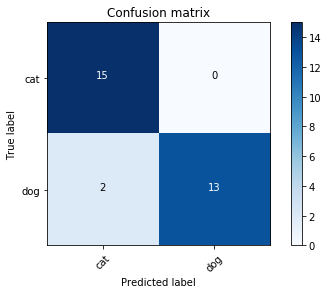

In [30]:
cm = confusion_matrix(val_classes, pred_classes)
plot_confusion_matrix(cm, { 'cat':0, 'dog':1})

### Experiment with training more than just the last layer

In [32]:
layers = model.layers

#### (a) Train first Dense layer and all subsequent layers

In [33]:
# get index of first Dense layer
first_dense_idx = [idx for idx, l in enumerate(model.layers) if type(l) is Dense][0]
# set it and all following layers to trainable
for l in model.layers[first_dense_idx:]: l.trainable = True

In [35]:
model.optimizer.lr = 0.01
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=1, 
                    validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
75/75 [==============================] - 21s - loss: 0.0056 - acc: 0.9967 - val_loss: 0.2370 - val_acc: 0.9333

In [36]:
model.save_weights(models_path + 'ft_last_layer2.h5')

#### (b) Train Layer 13 and all subsequent layers

In [37]:
for l in model.layers[12:]: l.trainable = True

In [38]:
model.optimizer.lr = 0.001
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=1, 
                    validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
75/75 [==============================] - 22s - loss: 7.8747e-04 - acc: 1.0000 - val_loss: 0.3872 - val_acc: 0.9333

In [39]:
model.save_weights(models_path + 'ft_last_layer3.h5')

In [41]:
model.evaluate_generator(val_batches, val_steps)
# model.evaluate(val_data, val_labels, batch_size=4)

[0.38720431665504784, 0.93333333333333335]

## 2. Precompute output from VGG's 2nd to last layer and use it to train a linear classifier.

In [44]:
limit_mem()
model = VGG19(weights='imagenet', include_top=True)
# model.summary()

### Pop last layer and set model.outputs = to that of the previously 2nd-to-last layer

In [45]:
model.layers.pop()

# model.layers[-1].outbound_nodes = [] ... this is not needed
model.outputs = [model.layers[-1].output]

### Precompute output for update model

In [46]:
train_features = model.predict(train_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

print(train_features.shape)
print(val_features.shape)

### Build Linear Classifier using precomputed output as input

In [48]:
lm = Sequential([ Dense(2, activation='softmax', input_shape=(4096,)) ])
lm.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
lm.fit(train_features, train_labels, batch_size=batch_size, epochs=1, shuffle=True, validation_data=(val_features, val_labels))

Train on 300 samples, validate on 30 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 0.2552 - acc: 0.9333 - val_loss: 0.1346 - val_acc: 0.9333


In [ ]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
imgs, labels = next(train_batches)

plots(imgs, titles=labels)

In [ ]:
preds = model.predict(imgs) # returns probabilities for each image ([ [.999, .01], [.825, .175] ])

In [ ]:
idxs = np.argmax(preds, axis=1) # returns index of highest probability for each image ([0,1,0,1])

In [ ]:
predicted_probs = [preds[i, idxs[i]] for i in range(len(idxs))] # returns probability of predicted label ([.99, 1.0])

In [ ]:
# train_batches.class_indices => {'cats': 0, 'dogs': 1}
model_classes = list(iter(train_batches.class_indices)) # returns ['cats', 'dogs']
classes = [model_classes[idx] for idx in idxs] # returns ['cats', 'dogs', 'cats', 'dogs']

In [ ]:
for i in range(len(idxs)):
    print('{0:.4f}/{1}'.format(predicted_probs[i], classes[i]))